# Optimizers

This tutorial presents the various optimizers available in `timm`. We look at how we could use each of them using the `timm` training script and also as standalone optimizers for custom PyTorch training scripts. 

The various optimizers available in `timm` are: 
1. [SGD](http://www.cs.toronto.edu/~hinton/absps/momentum.pdf)
2. [Adam](https://arxiv.org/abs/1412.6980)
3. [AdamW](https://www.fast.ai/2018/07/02/adam-weight-decay/)
4. [Nadam](http://cs229.stanford.edu/proj2015/054_report.pdf)
5. [Radam](https://arxiv.org/abs/1908.03265v1)
6. [AdamP](https://arxiv.org/abs/2006.08217)
7. [SGDP](https://arxiv.org/abs/2006.08217)
8. [Adadelta](https://arxiv.org/abs/1212.5701) 
9. [Adafactor](https://arxiv.org/abs/1804.04235)
10. [ADAHESSIAN](https://arxiv.org/abs/2006.00719)
11. [RMSprop](https://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf) 
12. [NovoGrad](https://arxiv.org/abs/1905.11286)

And some more from `apex` like:
1. [FusedSGD](https://nvidia.github.io/apex/optimizers.html#apex.optimizers.FusedSGD)
2. [FusedAdam](https://nvidia.github.io/apex/optimizers.html#apex.optimizers.FusedAdam)
3. [FusedLAMB](https://nvidia.github.io/apex/optimizers.html#apex.optimizers.FusedLAMB)
4. [FusedNovoGrad](https://nvidia.github.io/apex/optimizers.html#apex.optimizers.FusedNovoGrad)

which are GPU-only. 

`timm` also supports lookahead optimizer. 

As is the usual format for `timm`, the best way to create an optimizer using `timm` is to use the `create_optimizer` factory method. In this tutorial we will look at how to train each of these models using each of these optimizers using the `timm` training script first and also as standalone optimizers for custom training script.

## Using `timm` training script

To train using any of the optimizers simply pass the optimizer name using the `--opt` flag to the training script. 

```python 
python train.py ../imagenette-320/ --opt adam
```

Since `Lookahead` technique can be added to any of the optimizers, we can train our models using `Lookahead` in `timm`, simply update the optimizer name by adding a `lookahead_` prefix. Example for `adam`, the training script looks like: 

```python 
python train.py ../imagenette-320/ --opt lookahead_adam
```

And that's really it. This way we can train models on `ImageNet` or `Imagenette` using all the available optimizers in `timm`. 

## As standalone `optimizers` for custom training script

Many a time, we might just want to use the optimizers from timm for our own training scripts. The best way to create an optimizer using `timm` is to use the `create_optimizer` factory method. 

> NOTE: `create_optimizer` in `timm` accepts `args` as the first argument. This `args` parameter is from `ArgumentParser` so we might have to mock it to create optimizer for our custom training script. The example below shows how to do this. 

The arguments for `create_optimizer` are shown below:

```python 
def create_optimizer(args, model, filter_bias_and_bn=True) -> Union[Optimizer, Lookahead]:
    """
    Here, `args` are the arguments parsed by `ArgumentParser` in `timm` training script. 
    If we want to create an optimizer using this function, we should make sure that `args` has the 
    following attributes set: 
    
    args: Arguments from `ArgumentParser`:
    - `opt`: Optimizer name
    - `weight_decay`: Weight decay if any 
    - `lr`: Learning rate 
    - `momentum`: Decay rate for momentum if passed and not 0 
    
    model: Model that we want to train 
    """
```

Let's see how to mock the `args` below:

In [1]:
from types import SimpleNamespace
from timm.optim.optim_factory import create_optimizer
from timm import create_model 

model = create_model('resnet34')

args = SimpleNamespace()
args.weight_decay = 0
args.lr = 1e-4
args.opt = 'adam' #'lookahead_adam' to use `lookahead`
args.momentum = 0.9

optimizer = create_optimizer(args, model)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)

## Training NN using `timm` optimizers 

In this section we are going to try and experiment some of the various available optimizers and use them in our own custom training script. 

We will store the losses for each of the optimizers and in the end visualize the loss curves to compare performance on `Imagenette` dataset using a `resnet-34` model that we again create using `timm`.

In [2]:
import torch
import torch.optim as optim 
import timm
from timm.data import create_dataset, create_loader
import numpy as np 
from matplotlib import pyplot as plt
import torchvision
import torch.nn as nn 
from tqdm import tqdm
import logging 
from timm.optim import optim_factory
from types import SimpleNamespace
logging.getLogger().setLevel(logging.INFO)

In [3]:
# make sure you have this data, if not, download from here `https://github.com/fastai/imagenette`
DATA_DIR = '../imagenette2-320/'

### Data Dir

The directory structure of the data dir looks something like: 

```
imagenette2-320
├── train
│   ├── n01440764
│   ├── n02102040
│   ├── n02979186
│   ├── n03000684
│   ├── n03028079
│   ├── n03394916
│   ├── n03417042
│   ├── n03425413
│   ├── n03445777
│   └── n03888257
└── val
    ├── n01440764
    ├── n02102040
    ├── n02979186
    ├── n03000684
    ├── n03028079
    ├── n03394916
    ├── n03417042
    ├── n03425413
    ├── n03445777
    └── n03888257
```

### Train and Val dataset

Let's now create our train and validation datasets and dataloaders using `timm`. For more docs on datasets, refer [here](https://fastai.github.io/timmdocs/dataset).

In [4]:
train_dataset = create_dataset("train", DATA_DIR, "train")
train_loader  = create_loader(train_dataset, input_size=(3, 320, 320), batch_size=8, use_prefetcher=False, 
                              is_training=True, no_aug=True)
len(train_dataset)

9469

In [5]:
val_dataset = create_dataset("val", DATA_DIR, "val")
val_loader  = create_loader(val_dataset, input_size=(3, 320, 320), batch_size=64, use_prefetcher=False)
len(val_dataset)

3925

These are the class names that we have in `Imagenette`. We list them here for easy visualization below: 

In [6]:
# https://github.com/fastai/imagenette
class_names = ['tench', 'English springer', 'cassette player', 'chain saw', 'church', 
               'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute']

Let's now visualize some of the images and classes that our in our dataset. 

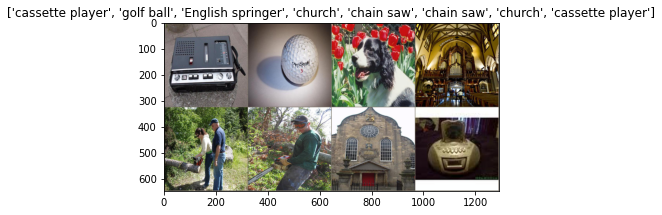

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

    
inputs, classes = next(iter(train_loader))[:8]
out = torchvision.utils.make_grid(inputs, nrow=4)
imshow(out, title=[class_names[x.item()] for x in classes])

It's great practice to visualize the images straight from the `train_loader` to check for any errors.

### Train one epoch

In this section we will create our custom training loop. 

In [8]:
# create loss and model
loss_fn = nn.CrossEntropyLoss()
model   = timm.create_model('resnet34', pretrained=False, num_classes=10)

In [9]:
# make sure we can do one forward pass
model(inputs).shape

torch.Size([8, 10])

The `AverageMeter` class below averages the loss for easy visualization. If we didn't take the moving average, then the loss curve would be very rocky and bumpy to visualize. 

> NOTE: As an experiment, feel free to remove the `loss_avg = AverageMeter()` in `train_one_epoch` function below and try visualizing the loss curve to see the difference. 

In [10]:
class AverageMeter:
    """
    Computes and stores the average and current value
    """

    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

The function below defines our custom training training loop. Essentially, we take the `inputs` and `targets` from the the `train_loader`. Get the predictions by passing the `inputs` through the model. Calculate the loss function, perform backpropogation using PyTorch to calculate the gradients. Finally, we use the optimizer to take step to update the parameters and zero out the gradients. 

Also, note that we store the moving average of the losses for each of the mini batch `losses.append(loss_avg.avg)` in a list called `losses`. Finally, we return a dictionary with the Optimizer name and the list `losses`. 

In [11]:
def train_one_epoch(args, loader, model, loss_fn = nn.CrossEntropyLoss(), **optim_kwargs):
    model   = timm.create_model('resnet34', pretrained=False, num_classes=10)
    logging.info(f"\ncreated model: {model.__class__.__name__}")
    
    optimizer = optim_factory.create_optimizer(args, model, **optim_kwargs)
    logging.info(f"created optimizer: {optimizer.__class__.__name__}")
    
    losses = []
    loss_avg = AverageMeter()
    model = model.cuda()
    tk0 = tqdm(enumerate(loader), total=len(loader))
    for i, (inputs, targets) in tk0:
        inputs = inputs.cuda()
        targets = targets.cuda()
        preds = model(inputs)
        loss = loss_fn(preds, targets)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_avg.update(loss.item(), loader.batch_size)
        losses.append(loss_avg.avg)
        tk0.set_postfix(loss=loss.item())
    
    return {args.opt: losses}

Note that this `train_one_epoch` function accepts `args`. These are the mocked `args` that we have looked at before. This `args` parameter get's passed to `optim_factory.create_optimizer` to create the Optimizer.

In [ ]:
# initialize empty losses dictionary
losses_dict = {}

In [ ]:
# mock the `args` parameter
args = SimpleNamespace()
args.weight_decay = 0 
args.lr = 1e-4
args.momentum = 0.9

Let's now pass in the various Optimizers. The training loop that we have created should take care of instantiating the `Optimizer` using the `create_optimizer` function. 

We have set the learning rate to be `1e-4`, weight decay and momentum both to be 0. 

We also pass in `lookahead_adam` to showcase training using the `Lookahead` class in `timm`. 

In [13]:
# train 1 epoch for each optimizer mentioned below
for opt in ['SGD', 'Adam', 'AdamW', 'Nadam', 'Radam', 'AdamP', 'Lookahead_Adam']:
    args.opt = opt
    loss_dict = train_one_epoch(args, train_loader, model)
    losses_dict.update(loss_dict)

INFO:root:
created model: ResNet
INFO:root:created optimizer: SGD
100%|██████████| 147/147 [00:30<00:00,  4.82it/s, loss=2.19]
INFO:root:
created model: ResNet
INFO:root:created optimizer: Adam
100%|██████████| 147/147 [00:30<00:00,  4.79it/s, loss=1.68]
INFO:root:
created model: ResNet
INFO:root:created optimizer: AdamW
100%|██████████| 147/147 [00:30<00:00,  4.77it/s, loss=1.77]
INFO:root:
created model: ResNet
INFO:root:created optimizer: Nadam
  0%|          | 0/147 [00:00<?, ?it/s]/home/aman_arora/git/experiments/pytorch-image-models/timm/optim/nadam.py:80: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  exp_avg.mul_(beta1).add_(1. - beta1, grad)
100%|██████████| 147/147 [00:30<00:00,  4.78it/s, loss=1.74]
INFO:root:
created model: ResNet
INFO:root:created optimizer: RAdam


### Comparing the performance of different optimizers

Finally, let's visualize the results to compare the performance. All the losses alongside the Optimizer passed were stored in `losses_dict`. 

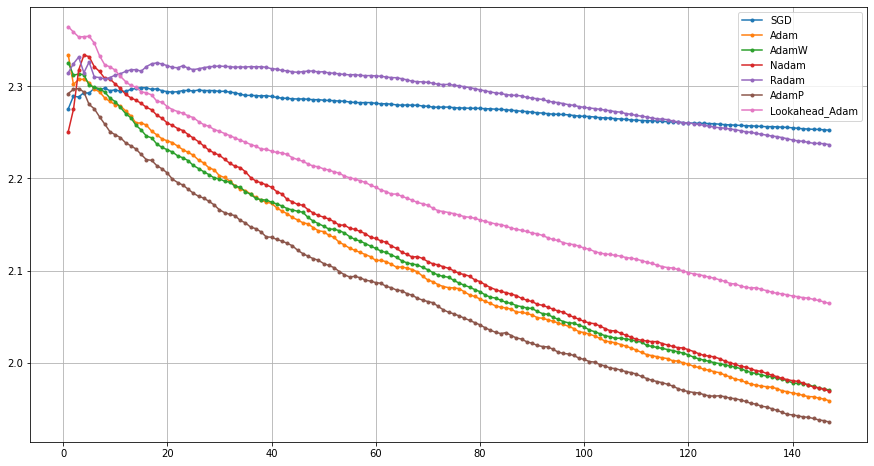

In [15]:
fig, ax = plt.subplots(figsize=(15,8))
for k, v in losses_dict.items():
    ax.plot(range(1, len(v) + 1), v, '.-', label=k)
    
ax.legend()  
ax.grid()

We can see that `Adam` and `AdamP` perform the best out of the available optimizers on `Imagenette` for the 1 epoch that we have trained our model for. After this, please feel free to run your own experiments! :) 